In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
data = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU3.csv')
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')
data.set_index('date', inplace=True)

# Calculate sizes based on percentages
total_size = len(data)
train_size = int(total_size * 0.85)
test_size = total_size - train_size

# Split the data
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [3]:
# Exogenous variables
exog_vars = ['New Year', 'Victory over Genocide Day', 'International Women Day', 'Khmer New Year Day 1',
             'Khmer New Year Day 2', 'Khmer New Year Day 3', 'Labour Day', 'Visak Bochea Day',
             'Royal Plowing Ceremony', "King's Birthday", "King's Mother's Birthday", 'Constitutional Day',
             'Pchum Ben Day 1', 'Pchum Ben Day 2', "Commemoration Day of King's Father", "King's Coronation Day",
             'Independence Day', 'Water Festival Day 1', 'Water Festival Day 2', 'Water Festival Day 3', 'Chrismas',
             'Discount Promotion', 'Loyalty Program Promotion', 'Bundle Promotion', 'Flash Sale Promotion']

# Prepare exogenous variables for training and testing
exog_train = train_data[exog_vars]
exog_test = test_data[exog_vars]

In [4]:
# Use Auto-ARIMA to find the best model parameters on training data
auto_arima_model = auto_arima(train_data['sales'],
                              exogenous=exog_train,
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

# Print the best model summary
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37443.103, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38319.863, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37920.844, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37454.521, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38317.863, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=37442.264, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=37445.115, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37454.439, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=37441.219, Time=1.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=37443.784, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=37443.337, Time=2.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=37442.864, Time=1.81 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=37445.131, Time=0.50 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=37443.284, Time=2.90 sec
 ARIMA(1,1,3)(0,0,0

In [5]:
# Initialize variables for rolling window prediction
lookback_period = 30  # 30 days lookback period
history_sales = train_data['sales'].copy()
history_exog = exog_train.copy()

# List to store predictions
predictions = []

# Ensure test data remains unseen by not using actual test values during prediction
for i in range(len(test_data)):
    # Current date index
    current_date = test_data.index[i]
    
    # Select the past 'lookback_period' days for training
    train_sales = history_sales[-lookback_period:]
    train_exog = history_exog[-lookback_period:]
    
    # Get exogenous variables for the current date
    exog_current = exog_test.iloc[i].values.reshape(1, -1)
    
    # Fit the ARIMAX model on the rolling window data
    model = auto_arima(train_sales,
                       exogenous=train_exog,
                       order=auto_arima_model.order,
                       seasonal=False,
                       suppress_warnings=True)
    
    # Predict the next day's sales
    forecast = model.predict(n_periods=1, exogenous=exog_current)
    
    # Append the prediction
    predictions.append(forecast[0])
    
    # Update history with the predicted value (not the actual test value)
    history_sales = pd.concat([history_sales, pd.Series(forecast[0], index=[current_date])])
    history_exog = pd.concat([history_exog, exog_test.iloc[i:i+1]])

    # Optional: Print progress
    if (i + 1) % 50 == 0 or (i + 1) == len(test_data):
        print(f"Completed {i + 1}/{len(test_data)} predictions")

Completed 50/274 predictions
Completed 100/274 predictions
Completed 150/274 predictions
Completed 200/274 predictions
Completed 250/274 predictions
Completed 274/274 predictions


In [6]:
# Convert the predictions list to a NumPy array for consistency
predictions = np.array(predictions)

In [7]:
import sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# Calculate MAE, MAPE, MSE, and R2
mae = mean_absolute_error(test_data['sales'], predictions)
mape = mean_absolute_percentage_error(test_data['sales'], predictions)
mse = mean_squared_error(test_data['sales'], predictions)
r2 = r2_score(test_data['sales'], predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

MAE: 116501.8923
MSE: 16097826846.5491
MAPE: 0.5311
R2: -7.2817


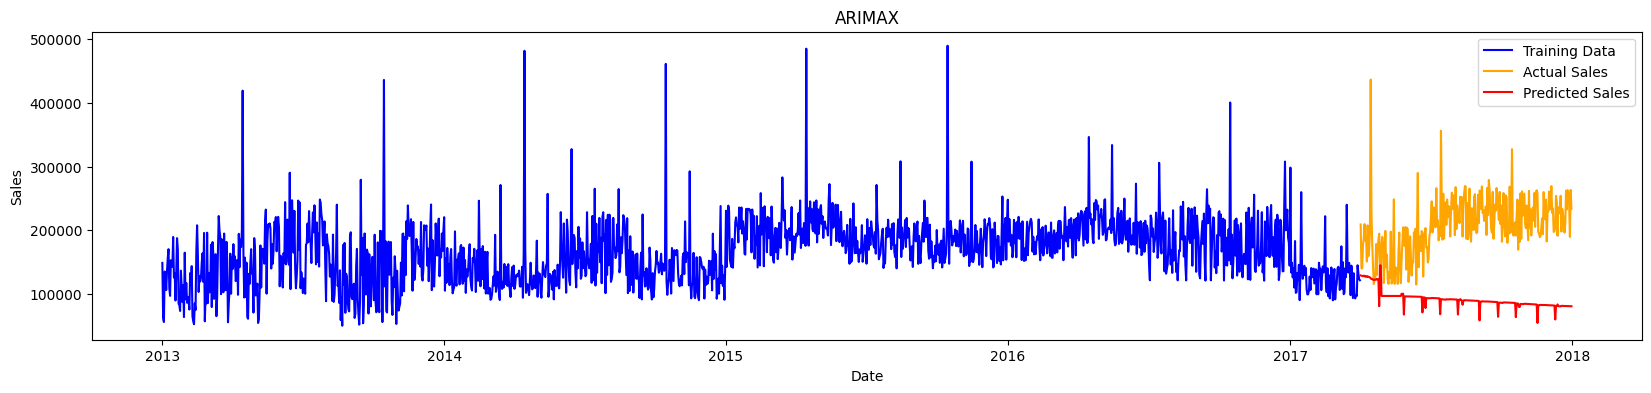

In [8]:
# Plotting the results
plt.figure(figsize=(20, 4))
plt.plot(train_data.index, train_data['sales'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['sales'], label='Actual Sales', color='orange')
plt.plot(test_data.index, predictions, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMAX')
plt.legend()
plt.show()

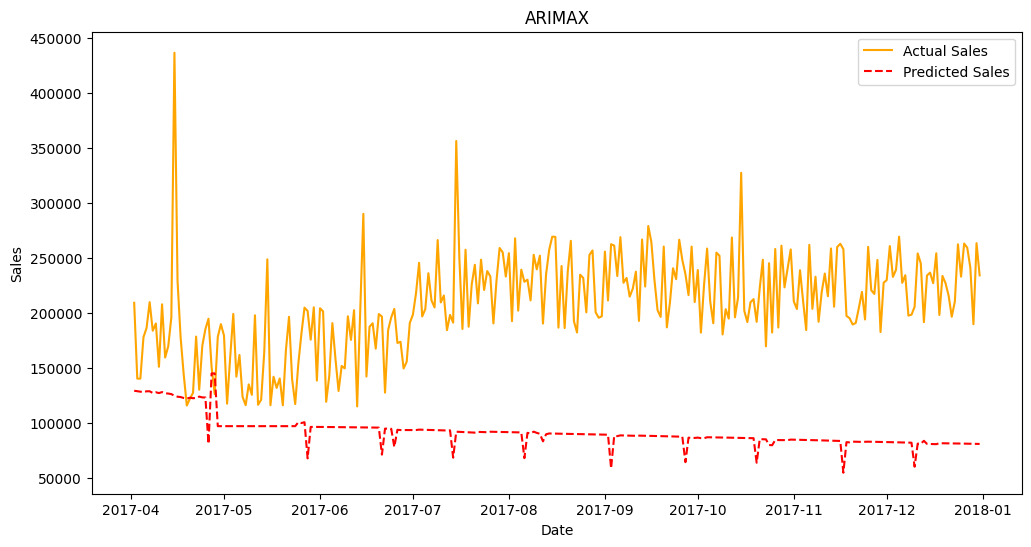

In [9]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['sales'], label='Actual Sales', color='orange')
plt.plot(test_data.index, predictions, label='Predicted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMAX')
plt.legend()
plt.show()